In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

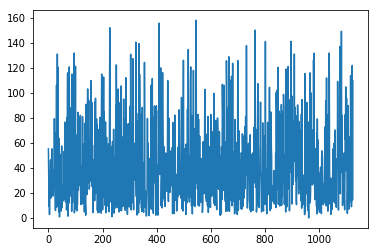

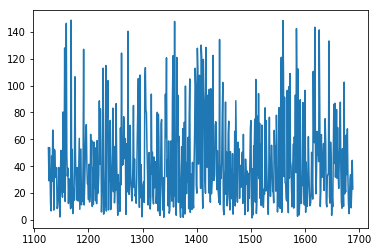

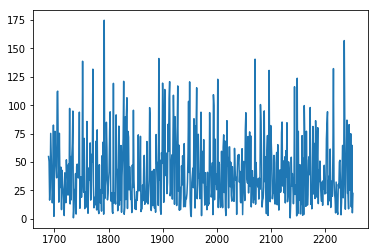

In [2]:
df = pd.read_pickle('data/micro_sud3_normalized.pkl')
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index()

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df):
    return (np.array(df[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                         'tgrad', 'pressure', 'pluvio']]),\
            np.array(df['NO2_ref']))

        
df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train)
X_valid, y_valid = dataframe_to_xy(df_valid)
X_test, y_test = dataframe_to_xy(df_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

def dataframe_to_xy_sequences(df, sequence_size):
    out_X = np.zeros((len(df)//sequence_size, sequence_size, 8))
    out_y = np.zeros((len(df)//sequence_size, sequence_size))
    i = 0
    while i + sequence_size < len(df):
        sequence = df.iloc[i:i+sequence_size]
        out_X[i//sequence_size] =  np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']])
        out_y[i//sequence_size] = np.array(sequence['NO2_ref'])
        i += sequence_size
        
    return out_X, out_y

plt.plot(df_train['NO2_ref'])
plt.show()

plt.plot(df_valid['NO2_ref'])
plt.show()

plt.plot(df_test['NO2_ref'])
plt.show()

In [3]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim, recurrent_dropout=1, activation='relu'))#, recurrent_dropout=1))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim, activation='relu'))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_dim, activation='relu'))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


In [4]:
print(X_train.shape)
model = simple_rnn_model(32, X_train.shape[1:])

(1126, 1, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


In [5]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 1s 633us/step - loss: 2703.6614 - val_loss: 2811.5555
Epoch 2/10000
1126/1126 [==============================] - 0s 73us/step - loss: 2579.3424 - val_loss: 2588.6240
Epoch 3/10000
1126/1126 [==============================] - 0s 74us/step - loss: 2251.3971 - val_loss: 2052.8480
Epoch 4/10000
1126/1126 [==============================] - 0s 71us/step - loss: 1596.0956 - val_loss: 1172.0424
Epoch 5/10000
1126/1126 [==============================] - 0s 75us/step - loss: 796.4403 - val_loss: 477.1721
Epoch 6/10000
1126/1126 [==============================] - 0s 77us/step - loss: 390.9057 - val_loss: 324.6948
Epoch 7/10000
1126/1126 [==============================] - 0s 73us/step - loss: 310.9859 - val_loss: 291.8602
Epoch 8/10000
1126/1126 [==============================] - 0s 67us/step - loss: 280.7700 - val_loss: 270.8609
Epoch 9/10000
1126/1126 [==============================] - 0s 71

Epoch 75/10000
1126/1126 [==============================] - 0s 63us/step - loss: 64.3256 - val_loss: 73.9597
Epoch 76/10000
1126/1126 [==============================] - 0s 69us/step - loss: 63.8063 - val_loss: 73.2687
Epoch 77/10000
1126/1126 [==============================] - 0s 67us/step - loss: 63.2051 - val_loss: 72.6939
Epoch 78/10000
1126/1126 [==============================] - 0s 66us/step - loss: 62.7538 - val_loss: 72.0307
Epoch 79/10000
1126/1126 [==============================] - 0s 68us/step - loss: 62.1738 - val_loss: 71.4797
Epoch 80/10000
1126/1126 [==============================] - 0s 68us/step - loss: 61.7426 - val_loss: 70.8637
Epoch 81/10000
1126/1126 [==============================] - 0s 68us/step - loss: 61.2133 - val_loss: 70.3213
Epoch 82/10000
1126/1126 [==============================] - 0s 62us/step - loss: 60.8065 - val_loss: 69.7626
Epoch 83/10000
1126/1126 [==============================] - 0s 65us/step - loss: 60.3252 - val_loss: 69.2457
Epoch 84/10000
1126

1126/1126 [==============================] - 0s 45us/step - loss: 44.1666 - val_loss: 52.0148
Epoch 224/10000
1126/1126 [==============================] - 0s 44us/step - loss: 44.0889 - val_loss: 51.9581
Epoch 225/10000
1126/1126 [==============================] - 0s 44us/step - loss: 44.0574 - val_loss: 51.9287
Epoch 226/10000
1126/1126 [==============================] - 0s 43us/step - loss: 44.0761 - val_loss: 51.8850
Epoch 227/10000
1126/1126 [==============================] - 0s 55us/step - loss: 43.9700 - val_loss: 51.8642
Epoch 228/10000
1126/1126 [==============================] - 0s 73us/step - loss: 43.9042 - val_loss: 51.8179
Epoch 229/10000
1126/1126 [==============================] - 0s 79us/step - loss: 43.9078 - val_loss: 51.8218
Epoch 230/10000
1126/1126 [==============================] - 0s 79us/step - loss: 43.8627 - val_loss: 51.7337
Epoch 231/10000
1126/1126 [==============================] - 0s 54us/step - loss: 43.8090 - val_loss: 51.7564
Epoch 232/10000
1126/1126 

1126/1126 [==============================] - 0s 73us/step - loss: 38.9102 - val_loss: 47.9168
Epoch 372/10000
1126/1126 [==============================] - 0s 66us/step - loss: 38.7676 - val_loss: 47.5618
Epoch 373/10000
1126/1126 [==============================] - 0s 68us/step - loss: 38.7282 - val_loss: 47.8060
Epoch 374/10000
1126/1126 [==============================] - 0s 68us/step - loss: 38.6349 - val_loss: 47.5741
Epoch 375/10000
1126/1126 [==============================] - 0s 69us/step - loss: 38.6369 - val_loss: 47.7754
Epoch 376/10000
1126/1126 [==============================] - 0s 70us/step - loss: 38.5724 - val_loss: 47.5754
Epoch 377/10000
1126/1126 [==============================] - 0s 70us/step - loss: 38.5472 - val_loss: 47.7347
Epoch 378/10000
1126/1126 [==============================] - 0s 70us/step - loss: 38.4919 - val_loss: 47.5574
Epoch 379/10000
1126/1126 [==============================] - 0s 68us/step - loss: 38.4778 - val_loss: 47.7339
Epoch 380/10000
1126/1126 

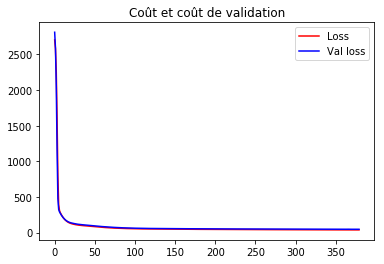

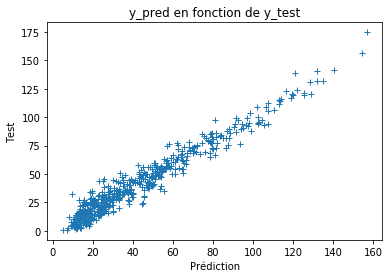

In [6]:
y_pred = model.predict(X_test, batch_size=32)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [7]:
model = lstm_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 1s 1ms/step - loss: 2737.1121 - val_loss: 2885.1294
Epoch 2/10000
1126/1126 [==============================] - ETA: 0s - loss: 2672.76 - 0s 100us/step - loss: 2702.1065 - val_loss: 2807.7091
Epoch 3/10000
1126/1126 [==============================] - 0s 104us/step - loss: 2544.5930 - val_loss: 2475.8458
Epoch 4/10000
1126/1126 [==============================] - 0s 98us/step - loss: 2032.2900 - val_loss: 1620.8646
Epoch 5/10000
1126/1126 [==============================] - 0s 100us/step - loss: 1156.1648 - val_loss: 762.6237
Epoch 6/10000
1126/1126 [==============================] - 0s 97us/step - loss: 663.2736 - val_loss: 608.9346
Epoch 7/10000
1126/1126 [==============================] - 0s 100us/step - loss: 565.2683 - val_loss: 535.5515
Epoch 8/10000
1126/1126 [==============================] - 0s 99us/step - loss: 501.6293 - val_loss: 476.4746
Epoch 9/10000
1126/1126 [==========

1126/1126 [==============================] - 0s 74us/step - loss: 40.0488 - val_loss: 51.1262
Epoch 149/10000
1126/1126 [==============================] - 0s 98us/step - loss: 39.9328 - val_loss: 50.9911
Epoch 150/10000
1126/1126 [==============================] - 0s 120us/step - loss: 39.7785 - val_loss: 50.8530
Epoch 151/10000
1126/1126 [==============================] - 0s 104us/step - loss: 39.6531 - val_loss: 50.7821
Epoch 152/10000
1126/1126 [==============================] - 0s 93us/step - loss: 39.5180 - val_loss: 50.5748
Epoch 153/10000
1126/1126 [==============================] - 0s 71us/step - loss: 39.3994 - val_loss: 50.4886
Epoch 154/10000
1126/1126 [==============================] - 0s 71us/step - loss: 39.2666 - val_loss: 50.2617
Epoch 155/10000
1126/1126 [==============================] - 0s 74us/step - loss: 39.1182 - val_loss: 50.2302
Epoch 156/10000
1126/1126 [==============================] - 0s 83us/step - loss: 39.0022 - val_loss: 50.0627
Epoch 157/10000
1126/112

1126/1126 [==============================] - 0s 106us/step - loss: 31.5481 - val_loss: 44.1935
Epoch 297/10000
1126/1126 [==============================] - 0s 96us/step - loss: 31.5268 - val_loss: 44.2807
Epoch 298/10000
1126/1126 [==============================] - 0s 98us/step - loss: 31.4836 - val_loss: 44.1341
Epoch 299/10000
1126/1126 [==============================] - 0s 96us/step - loss: 31.4462 - val_loss: 44.1969
Epoch 300/10000
1126/1126 [==============================] - 0s 98us/step - loss: 31.4623 - val_loss: 44.2095
Epoch 301/10000
1126/1126 [==============================] - 0s 99us/step - loss: 31.4056 - val_loss: 44.1133
Epoch 302/10000
1126/1126 [==============================] - 0s 99us/step - loss: 31.3934 - val_loss: 44.1745
Epoch 303/10000
1126/1126 [==============================] - 0s 99us/step - loss: 31.3465 - val_loss: 44.0892
Epoch 304/10000
1126/1126 [==============================] - 0s 103us/step - loss: 31.3182 - val_loss: 44.1143
Epoch 305/10000
1126/112

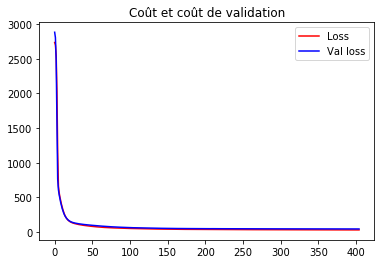

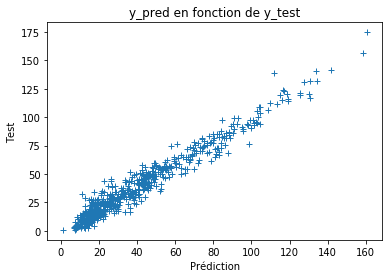

In [9]:
y_pred = model.predict(X_test)
y_test.reshape(len(y_test))
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [10]:
model = gru_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1126 samples, validate on 563 samples
Epoch 1/10000
1126/1126 [==============================] - 1s 1ms/step - loss: 2737.9662 - val_loss: 2884.6265
Epoch 2/10000
1126/1126 [==============================] - 0s 107us/step - loss: 2699.7910 - val_loss: 2802.4158
Epoch 3/10000
1126/1126 [==============================] - 0s 90us/step - loss: 2542.4833 - val_loss: 2492.4745
Epoch 4/10000
1126/1126 [==============================] - 0s 76us/step - loss: 2081.5469 - val_loss: 1747.4053
Epoch 5/10000
1126/1126 [==============================] - 0s 117us/step - loss: 1276.7518 - val_loss: 845.9476
Epoch 6/10000
1126/1126 [==============================] - 0s 109us/step - loss: 645.8847 - val_loss: 521.3024
Epoch 7/10000
1126/1126 [==============================] - 0s 71us/step - loss: 493.9093 - val_loss: 468.6530
Epoch 8/10000
1126/1126 [==============================] - 0s 64us/step - loss: 439.7839 - val_loss: 414.8487
Epoch 9/10000
1126/1126 [==============================] - 0s 

Epoch 75/10000
1126/1126 [==============================] - 0s 89us/step - loss: 54.0157 - val_loss: 62.2957
Epoch 76/10000
1126/1126 [==============================] - 0s 75us/step - loss: 53.7341 - val_loss: 61.9313
Epoch 77/10000
1126/1126 [==============================] - 0s 58us/step - loss: 53.4675 - val_loss: 61.5646
Epoch 78/10000
1126/1126 [==============================] - 0s 59us/step - loss: 53.2068 - val_loss: 61.2149
Epoch 79/10000
1126/1126 [==============================] - 0s 60us/step - loss: 52.9565 - val_loss: 60.8821
Epoch 80/10000
1126/1126 [==============================] - 0s 59us/step - loss: 52.7048 - val_loss: 60.5698
Epoch 81/10000
1126/1126 [==============================] - 0s 60us/step - loss: 52.4641 - val_loss: 60.2308
Epoch 82/10000
1126/1126 [==============================] - 0s 61us/step - loss: 52.2390 - val_loss: 59.9213
Epoch 83/10000
1126/1126 [==============================] - 0s 59us/step - loss: 52.0099 - val_loss: 59.5999
Epoch 84/10000
1126

1126/1126 [==============================] - 0s 93us/step - loss: 36.3406 - val_loss: 43.8408
Epoch 224/10000
1126/1126 [==============================] - 0s 86us/step - loss: 36.3373 - val_loss: 44.0364
Epoch 225/10000
1126/1126 [==============================] - 0s 94us/step - loss: 36.2489 - val_loss: 43.7373
Epoch 226/10000
1126/1126 [==============================] - 0s 91us/step - loss: 36.2272 - val_loss: 43.9369
Epoch 227/10000
1126/1126 [==============================] - 0s 93us/step - loss: 36.1095 - val_loss: 43.6303
Epoch 228/10000
1126/1126 [==============================] - 0s 95us/step - loss: 36.0703 - val_loss: 43.8060
Epoch 229/10000
1126/1126 [==============================] - 0s 100us/step - loss: 35.9760 - val_loss: 43.5364
Epoch 230/10000
1126/1126 [==============================] - 0s 96us/step - loss: 35.9257 - val_loss: 43.6663
Epoch 231/10000
1126/1126 [==============================] - 0s 94us/step - loss: 35.8278 - val_loss: 43.4576
Epoch 232/10000
1126/1126

1126/1126 [==============================] - 0s 96us/step - loss: 29.5873 - val_loss: 40.4399
Epoch 372/10000
1126/1126 [==============================] - 0s 89us/step - loss: 29.5683 - val_loss: 40.4256
Epoch 373/10000
1126/1126 [==============================] - 0s 91us/step - loss: 29.6009 - val_loss: 40.4314
Epoch 374/10000
1126/1126 [==============================] - 0s 89us/step - loss: 29.5509 - val_loss: 40.4603
Epoch 375/10000
1126/1126 [==============================] - 0s 90us/step - loss: 29.5742 - val_loss: 40.4108
Epoch 376/10000
1126/1126 [==============================] - 0s 91us/step - loss: 29.4864 - val_loss: 40.4479
Epoch 377/10000
1126/1126 [==============================] - 0s 93us/step - loss: 29.4829 - val_loss: 40.3899
Epoch 378/10000
1126/1126 [==============================] - 0s 93us/step - loss: 29.4246 - val_loss: 40.4190
Epoch 379/10000
1126/1126 [==============================] - 0s 93us/step - loss: 29.4151 - val_loss: 40.3675
Epoch 380/10000
1126/1126 

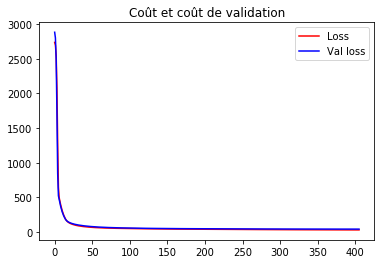

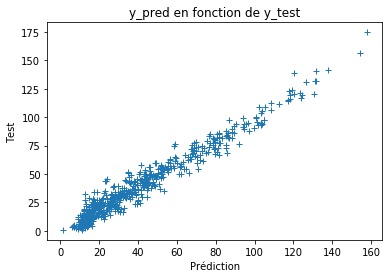

In [12]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [13]:
y_test.reshape(len(y_test)).shape

(564,)